In [5]:
import torch
import numpy as np
from odl.contrib import fom
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from array_api_compat import to_device
import array_api_compat.torch as xp
from utils.data import *
from einops import rearrange
from utils.geometry import *
from odl.contrib import fom
from utils.evaluate import *

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
for i in range(torch.cuda.device_count()):
    mem = torch.cuda.mem_get_info(i)
    if mem[1] != 0:
        print(i, mem[0]/mem[1])
    else:
        print(i, 0)

0 0.936637914552139
1 0.7075423770478371
2 0.3063930208293501
3 0.6995012536941642
4 0.30044958182880926
5 0.37254655602838427
6 0.22200492737314198
7 0.01646463708421875


In [2]:
torch.cuda.set_device(1)

In [ ]:
from models.lpdUnet import *

n_iter = 3
proj = get_minipet_projector(dev, num_rings=35)
normalisation=(proj.norm(xp,"cuda"))**2
model = LPD(n_iter, proj, normalisation, return_all=False)

model.to(dev)
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

loss_function = nn.MSELoss()

cp = torch.load("/home/mamo_alegua/anaconda3/LPDTransformer/"+"3iterUnet150",map_location='cpu')
model.load_state_dict(cp['model'])

In [ ]:
from models.lpdTransformer import *

n_iter = 3
proj = get_minipet_projector(dev, num_rings=35)
normalisation=(proj.norm(xp,"cuda"))**2
model = LPD(n_iter, proj, normalisation, patch_sinogram(proj, patch_size=(7,7), return_values=True), return_all=False)

model.to(dev)
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

loss_function = nn.MSELoss()

cp = torch.load("/home/mamo_alegua/anaconda3/LPDTransformer/"+"3iterTransformerDualV7Sino150",map_location='cpu')
model.load_state_dict(cp['model'])
del cp

In [ ]:
from models.restormerLPD import *

n_iter = 3
proj = get_minipet_projector(dev, num_rings=1)
normalisation=(proj.norm(xp,"cuda"))**2
model = LPD(n_iter, proj, normalisation,return_all=False)

model.to(dev)
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

loss_function = nn.MSELoss()

cp = torch.load("/mnt/imagingnas/data/Users/mct/anton/3iterR150",map_location='cpu')
model.module.load_state_dict(cp['model'])
del cp

In [ ]:
from models.lpdUnetCrossAttention import *

n_iter = 3
proj = get_minipet_projector(dev, num_rings=35)
normalisation=(proj.norm(xp,"cuda"))**2
model = LPD(n_iter, proj, normalisation, patch_sinogram(proj, patch_size=(7,7), return_values=True), return_all=False)

model.to(dev)
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

loss_function = nn.MSELoss()

cp = torch.load("/home/mamo_alegua/anaconda3/LPDTransformer/"+"3iterUnetCA150",map_location='cpu')
model.load_state_dict(cp['model'])
del cp

In [4]:
noise_levels = [0.3,0.7,1.0]
for i in noise_levels:
    res = evaluate(model, proj, dev, i, n=5)
    print("Noise level {:}; Loss {:.6f}; PSNR {:.3f}; SSIM {:.3f}".format(i, res[2], res[1], res[0]))

Noise level 0.3; Loss 0.005396; PSNR 22.712; SSIM 0.925
Noise level 0.7; Loss 0.006133; PSNR 22.176; SSIM 0.915
Noise level 1.0; Loss 0.006721; PSNR 21.832; SSIM 0.904


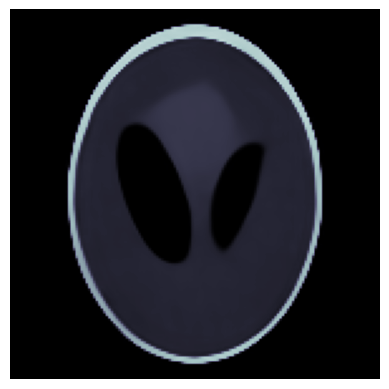

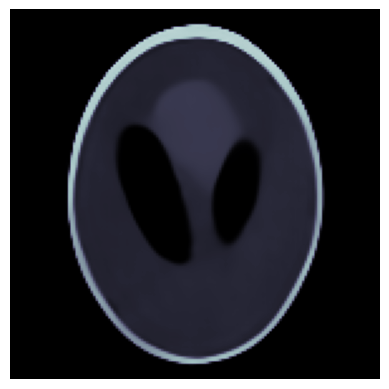

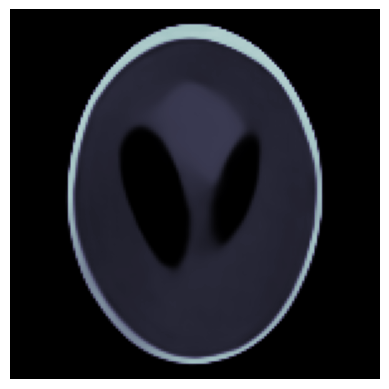

In [8]:
noise_levels = [0.3,0.7,1.0]
for i in noise_levels:
    plot_reconstructed_images(model, proj, dev, i, idx=16, legend=False)  

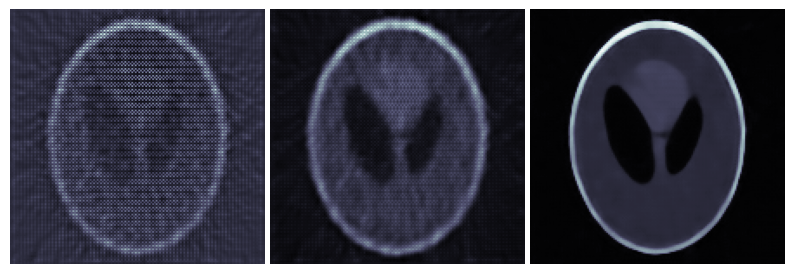

In [8]:
model.return_all = True
visualize_unrolling(model,proj,dev,noise_level=0.7,idx=16)
model.return_all = False

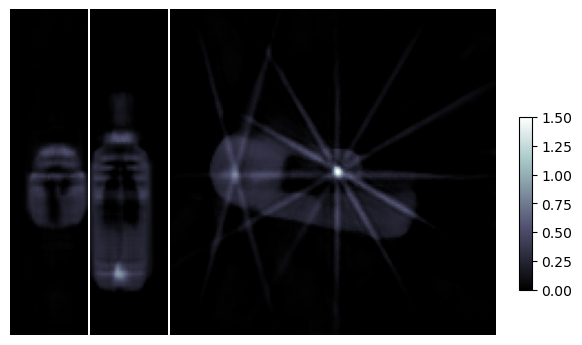

In [6]:
plot_miniPET(model,proj,dev,legend=True)

In [ ]:
plot_miniPET(model,proj,dev, all=True)

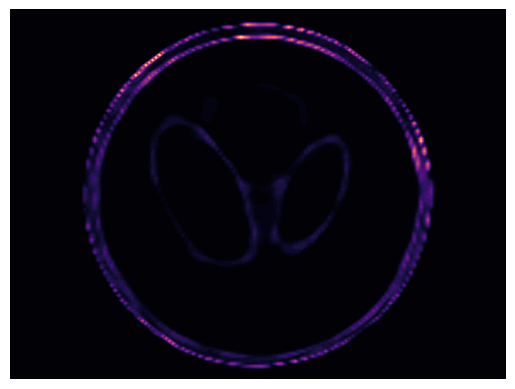

In [11]:
plot_var(model,proj,dev,noise_level=1.0,n=10)

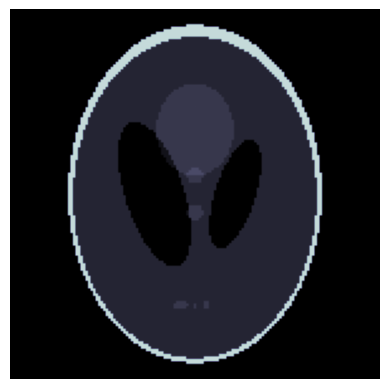

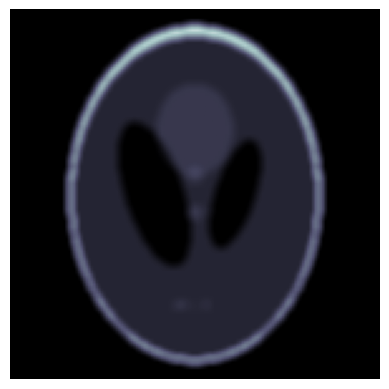

In [12]:
SLP = get_SLP(dev)
blurred_slices = blur_image(SLP, kernel_size=5, sigma=2.0)

idx = 16

plt.imshow(SLP[0,:,idx,:].cpu().numpy(), cmap='bone', clim=[0,1.2])
plt.axis('off')
plt.show()

plt.imshow(blurred_slices.cpu().numpy()[0,:,idx,:], cmap='bone', clim=[0,1.2])
plt.axis('off')
plt.show()

In [9]:
psnr_list = []
ssim_list = []
loss_list = []

In [ ]:
noise_levels = np.arange(0.1,1.3,0.1)
model_psnr_list = []
model_ssim_list = []
model_loss_list = []

for i in noise_levels:
    ssim, psnr, loss = evaluate(model, proj, i, n=3)
    model_ssim_list.append(ssim), model_psnr_list.append(psnr), model_loss_list.append(loss)

psnr_list.append(model_psnr_list), ssim_list.append(model_ssim_list), loss_list.append(model_loss_list)

In [ ]:
models = ['U-Net','Dual-Domain Transformer','Restormer','U-Net CAB']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(models)):
    axs[0].plot(noise_levels, psnr_list[i])
axs[0].set_xlabel('Noise level')
axs[0].set_ylabel('PSNR')


for i in range(len(models)):
    axs[1].plot(noise_levels, ssim_list[i])
axs[1].set_xlabel('Noise level')
axs[1].set_ylabel('SSIM')


for i in range(len(models)):
    axs[2].plot(noise_levels, loss_list[i])
axs[2].set_xlabel('Noise level')
axs[2].set_ylabel('MSE')

fig.legend(models, loc='center left', bbox_to_anchor=(1.02, 0.9))

plt.tight_layout()
plt.show()

In [ ]:
rs=odl.uniform_discr([  0. , -21.9, -21.9], [  0.675,  22.2  ,  22.2  ], (147, 147, 60), dtype='float32')
SLP = odl.phantom.shepp_logan(rs,modified=True)

SLP_slices = torch.flip(rearrange(to_device(
    torch.tensor(SLP),
    dev), 'w h d -> h d w')[:,13:48,:].unsqueeze(0),[1])

SLP_slices[SLP_slices < 0] = 0
blurred_slices = blur_image(SLP_slices, kernel_size=5, sigma=2.0)

noise = np.arange(0.1,1.3,0.1)
psnr = []
ssim = []
loss_noise = []

SLP_slices[SLP_slices < 0] = 0
blurred_slices = blur_image(SLP_slices, kernel_size=5, sigma=2.0)
blurred_slices = rearrange(blurred_slices, 'b h (d1 d2) w -> (b d1) h d2 w', d2=1)
SLP_slices = rearrange(SLP_slices, 'b h (d1 d2) w -> (b d1) h d2 w', d2=1)

for i in noise:
    loganSin = generate_data(blurred_slices,proj,noise_level=i)

    ssim_list = []
    psnr_list = []
    loss = 0

    with torch.no_grad():
        sino, images = to_device(loganSin,dev), to_device(SLP_slices,dev)
        outputs = model(sino)

        loss += loss_function(outputs, images).item()
        for b in range(images.shape[0]):
            for i in range(images.shape[2]):
                psnr_list.append(fom.psnr(outputs[b,:,i,:].cpu().numpy(),images[b,:,i,:].cpu().numpy()))
                ssim_list.append(fom.ssim(outputs[b,:,i,:].cpu(),images[b,:,i,:].cpu()))

    psnr.append(np.mean(psnr_list))
    ssim.append(np.mean(ssim_list))
    loss_noise.append(loss)


psnr_list.append(psnr)
ssim_list.append(ssim)
loss_list.append(loss_noise)